Tesseract OCR이 오픈소스이며 무료로 사용할 수 있는 것으로, 개발자들이 직접 구현하여 사용할 수 있습니다.

## OCR
<HR> 

* mkdir -p ~/aiffel/ocr_python
* 구글 OCR API
* pip install --upgrade google-api-python-client
* pip install google-cloud-vision

[구글 사용법](http://egloos.zum.com/mcchae/v/11342622)

* 인증키 경로 등록 후 커널 재기동 / export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json

* 환경변수 설정 echo "export GOOGLE_APPLICATION_CREDENTIALS=$HOME/aiffel/ocr_python/my_google_api_key.json" >> ~/.bashrc

In [1]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [2]:
# 유료로 전환시 가능
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
#!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/graph.png' 

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
#detect_text(path)

유료기 때문에 사용하지않는걸로 했다.

## keras-ocr
* pip install keras-ocr
* echo "export TF_FORCE_GPU_ALLOW_GROWTH=true" >> ~/.bashrc
* echo $TF_FORCE_GPU_ALLOW_GROWTH

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

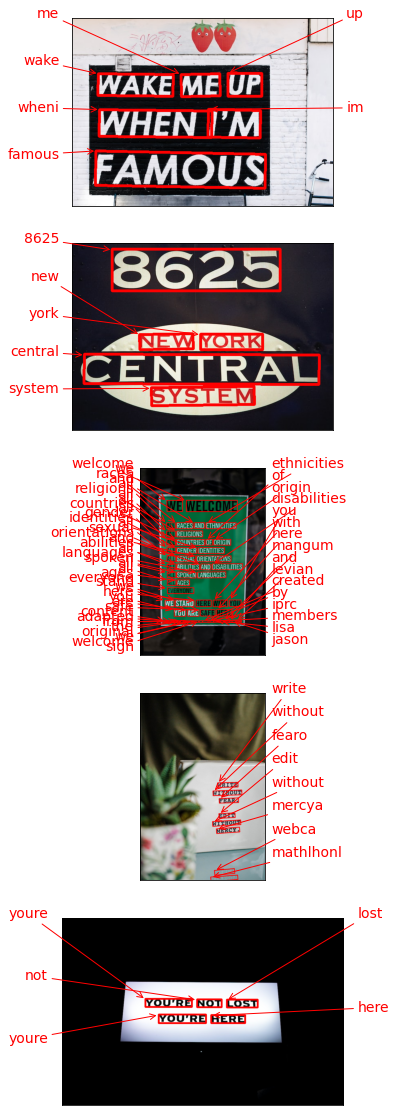

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

In [6]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


# 1) 테서랙트 설치하기
* 테서랙트는 아래 명령어로 설치할 수 있습니다. 클라우드 환경에는 이미 설치되어 있으니 확인만 하고 넘어갑니다.

* $ sudo apt install tesseract-ocr

 $ sudo apt install libtesseract-dev

# 2) 테서랙트 파이썬 wrapper 설치하기
Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)입니다. 파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해줍니다.

* Pytesseract
* 위키백과: 래퍼 라이브러리
* 클라우드 컨테이너에는 이미 설치가 되어 있습니다. 아래 명령어로 확인할 수 있어요.

$ pip list | grep pytesseract


# 3) 테서랙트로 문자 검출하고 이미지 자르기 (detection)
테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데요. 우리는 OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해 봅시다.

* 테서랙트 <br>
테서랙트 설치
    * ```sudo apt install tesseract-ocr```
    * ```sudo apt install libtesseract-dev```<br>
테서랙트 파이썬 wrapper 설치
    * ```pip install pytesseract```
<br>
테서렉트 한글 언어팩 설치
    * ```sudo apt install tesseract-ocr-kor```

In [7]:
# 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)
    
    # 기본적으로 image_to_data를 씀
    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        # Output을 이용해 Dict형태로 출력
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/ocr_1.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/0000.png


In [8]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

고  ' | 포 이 , 1

Done


결과가 그렇게 좋지는 않는다.

## opencv와 테서랙트ocr 결합을 하려한 노력들

In [9]:
# import cv2

# # 이미지 파일을 읽어옵니다.
# img = cv2.imread('/aiffel/aiffel/ocr_python/'+ '/ocr_1.jpg')

# # 이미지 파일이 없는 경우, 경고 메시지를 출력합니다.
# if img is None:
#     print("이미지 파일을 읽어올 수 없습니다.")

In [10]:
# print(img.shape)

In [11]:
# width = 320
# height = int(img.shape[0] * width / img.shape[1])
# img_resized = cv2.resize(img, (width, height))


In [12]:
# print(img_resized.shape)

In [13]:
# img = img_resized

In [14]:
# import cv2
# import pytesseract
# import os

# # 이미지 파일을 읽어옵니다.
# # img = cv2.imread('/aiffel/aiffel/ocr_python/'+ '/ocr_1.jpg')

# # 이미지 크기를 축소합니다.
# #scale_percent = 50  # 이미지를 축소할 비율
# #width = int(img.shape[1] * scale_percent / 100)
# #height = int(img.shape[0] * scale_percent / 100)
# #dim = (width, height)
# #img = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

# # 이미지를 그레이 스케일로 변환합니다.
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # Tesseract OCR을 이용하여 이미지 위의 텍스트를 추출합니다.
# text = pytesseract.image_to_string(gray, lang='kor')

# # 추출한 텍스트를 콘솔에 출력합니다.
# print(text)

# # 추출한 텍스트를 이미지 위에 표시합니다.
# cv2.putText(img, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# # 이미지 파일의 크기를 줄입니다.
# #new_size = (int(img.shape[1] / 2), int(img.shape[0] / 2))  # 이미지를 1/2로 줄임
# #resized_img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
# #cv2.imwrite('resized_image.jpg', resized_img)

# # 이미지를 화면에 표시합니다.
# cv2.imshow('Image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [15]:
# import cv2
# import pytesseract

# # 이미지 파일을 읽어옵니다.
# #img = cv2.imread('image.jpg')

# # 이미지를 2x2로 나누어 처리합니다.
# rows, cols, channels = img.shape
# step_row = rows // 2
# step_col = cols // 2
# for row in range(0, rows, step_row):
#     for col in range(0, cols, step_col):
#         # 이미지의 일부분을 잘라내어 처리합니다.
#         img_part = img[row:row+step_row, col:col+step_col]

#         # 이미지를 그레이 스케일로 변환합니다.
#         gray = cv2.cvtColor(img_part, cv2.COLOR_BGR2GRAY)

#         # Tesseract OCR을 이용하여 이미지 위의 텍스트를 추출합니다.
#         text = pytesseract.image_to_string(gray, lang='kor')

#         # 추출한 텍스트를 이미지 위에 표시합니다.
#         cv2.putText(img_part, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# # 전체 이미지를 화면에 표시합니다.
# cv2.imshow('Image', img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [16]:
# import cv2
# import pytesseract

# # 이미지 파일을 읽어옵니다.
# # img = cv2.imread('image.jpg')

# # 이미지를 그레이 스케일로 변환합니다.
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# # Otsu's thresholding 방법을 사용하여 이미지를 이진화합니다.
# thresh, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# # Tesseract OCR을 이용하여 이미지 위의 텍스트를 추출합니다.
# text = pytesseract.image_to_string(binary, lang='kor')

# # 추출한 텍스트를 콘솔에 출력합니다.
# print(text)

# # 추출한 텍스트를 이미지 위에 표시합니다.
# cv2.putText(img, text, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

# # 이미지를 화면에 표시합니다.
# cv2.imshow('Image', img)
# cv2.waitKey(1)
# cv2.destroyAllWindows()

여러 가지 방법을 해도 커널이죽는다.

그냥 쓰지않는것이 좋겠다. 성능도 그다지 좋지않는다.

## keras_ocr을 쓰기로했다.

In [17]:
import matplotlib.pyplot as plt
import keras_ocr
import os

image_urls = [
  os.getenv('HOME')+'/aiffel/ocr_python/OCR2.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR3.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR4.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR5.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR6.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR7.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR8.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR9.jpg',
  os.getenv('HOME')+'/aiffel/ocr_python/OCR10.jpg',  
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

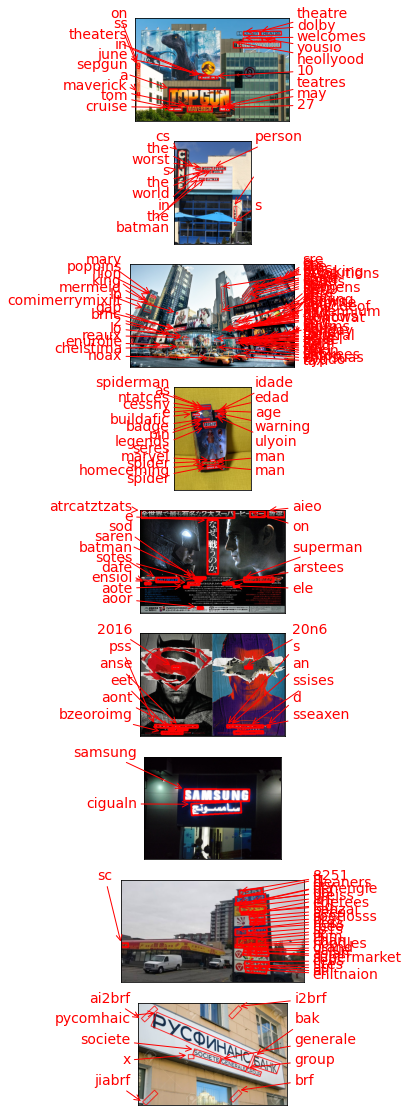

In [18]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

혹시나 한국어만 안돼나 다른언어도 넣어봤더니, 영어만 인식했다.

### 정리
* 구글 API는 유료전환 문제로 인해 사용해보지 못했음.
* keras에서는 영어로 만들어져있어 영어를 정확하게 인식하는 편이었으나 다른 언어는 패치가 되지 않아 인식이 정확하지 않았다.
* 테서렉트의 경우는 성능이 엉망이었다. 이미지 분할 후 인식하는 것이라 그런가 정확한 문장 단위의 선명한 이미지가 아니거나 1,2개의 단어만 있을 경우엔 제대로 인식하지 못했다

무료버전에서는 영어로는 케라스 ocr이 그나마 유의미 하게 나오고, 한국어는 못쓸정도로 엉망이었다. 한국어를 쓰려면 다른 ocr api를 써야한다.

# 회고

오랜만의 이미지라서 재밌게 봤지만, 결과는 실망스러운 OCR들이 많아서 약간 실망스러웠다. 하지만, 유료 OCR을 쓴다면, 좀 더 유의미하고 정확한 OCR을 쓸 수 있을 것 같았고, 이 OCR들을 만들려면 엄청난 자원들을 투자해야 하는 일 같았다.

좀 더 공부해서 좀 더 좋은 OCR 들을 만 들 수 있는 실력이 됬으면 좋겠다.